**Topic Models**, in a nutshell, are a type of statistical language models used for uncovering hidden structure in a collection of texts. In a practical and more intuitively, you can think of it as a task of:

**1. Dimensionality Reduction**, where rather than representing a text T in its feature space as {Word_i: count(Word_i, T) for Word_i in Vocabulary}, you can represent it in a topic space as {Topic_i: Weight(Topic_i, T) for Topic_i in Topics}

**2. Unsupervised Learning**, where it can be compared to clustering, as in the case of clustering, the number of topics, like the number of clusters, is an output parameter. By doing topic modeling, we build clusters of words rather than clusters of texts. A text is thus a mixture of all the topics, each having a specific weight.

**3. Tagging**, abstract “topics” that occur in a collection of documents that best represents the information in them.

There are several existing algorithms you can use to perform the topic modeling. The most common of it are, Latent Semantic Analysis (LSA/LSI), Probabilistic Latent Semantic Analysis (pLSA), and Latent Dirichlet Allocation (LDA)

### Parameters of LDA

**Alpha parameter** is Dirichlet prior concentration parameter that represents document-topic density — with a higher alpha, documents are assumed to be made up of more topics and result in more specific topic distribution per document.

**Beta parameter** is the same prior concentration parameter that represents topic-word density — with high beta, topics are assumed to made of up most of the words and result in a more specific word distribution per topic.

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Loading data

- The dataset is of papers published in NeurIPS (NIPS) conference which is one of the most prestigious yearly events in the machine learning community. 
- The CSV data file contains information on the different NeurIPS papers that were published from 1987 until 2016 (29 years!). 
- These papers discuss a wide variety of topics in machine learning, from neural networks to optimization methods, and many more.

In [2]:
# Importing modules
import pandas as pd
# Read data into papers
papers = pd.read_csv('papers.csv')

In [3]:
# Print head
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In [4]:
papers.shape

(6560, 7)

## Data Cleaning

Tgoal of this analysis is to perform topic modeling, let’s focus only on the text data from each paper, and drop other metadata columns.

In [5]:
# Remove the columns
papers = papers.drop(columns=['id', 'event_type', 'pdf_name'], axis=1).sample(100)

In [6]:
# Print out the first rows of papers
papers.head()

,year,title,abstract,paper_text
1029,2000,Discovering Hidden Variables: A Structure-Base...,Abstract Missing,Discovering Hidden Variables:\nA Structure-Bas...
4509,2013,Robust Low Rank Kernel Embeddings of Multivari...,Kernel embedding of distributions has led to m...,Robust Low Rank Kernel Embeddings of\nMultivar...
447,1997,Use of a Multi-Layer Perceptron to Predict Mal...,Abstract Missing,Reinforcement Learning for Continuous\nStochas...
4108,2012,Analog readout for optical reservoir computers,"Reservoir computing is a new, powerful and fle...",Analog readout for optical reservoir computers...
1515,2003,Policy Search by Dynamic Programming,Abstract Missing,Policy search by dynamic programming\n\nJ. And...


#### Remove punctuation/lower casing

In [7]:
# Load the regular expression library
import re
# Remove punctuation
papers['paper_text_processed'] = papers['paper_text'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: x.lower())

In [8]:
# Print out the first rows of papers
papers.head()

,year,title,abstract,paper_text,paper_text_processed
1029,2000,Discovering Hidden Variables: A Structure-Base...,Abstract Missing,Discovering Hidden Variables:\nA Structure-Bas...,discovering hidden variables:\na structure-bas...
4509,2013,Robust Low Rank Kernel Embeddings of Multivari...,Kernel embedding of distributions has led to m...,Robust Low Rank Kernel Embeddings of\nMultivar...,robust low rank kernel embeddings of\nmultivar...
447,1997,Use of a Multi-Layer Perceptron to Predict Mal...,Abstract Missing,Reinforcement Learning for Continuous\nStochas...,reinforcement learning for continuous\nstochas...
4108,2012,Analog readout for optical reservoir computers,"Reservoir computing is a new, powerful and fle...",Analog readout for optical reservoir computers...,analog readout for optical reservoir computers...
1515,2003,Policy Search by Dynamic Programming,Abstract Missing,Policy search by dynamic programming\n\nJ. And...,policy search by dynamic programming\n\nj andr...


## Exploratory Analysis

- To verify whether the preprocessing, we’ll make a word cloud using the wordcloud package to get a visual representation of most common words. 
- It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model

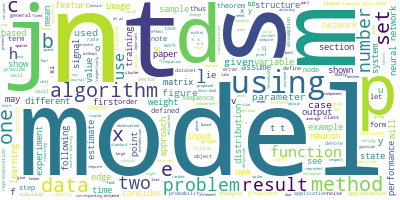

In [9]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(papers['paper_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

## Prepare data for LDA Analysis
- Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model.
- We start by tokenizing the text and removing stopwords. 
- Next, we convert the tokenized object into a corpus and dictionary.

In [10]:
import gensim
from gensim.utils import simple_preprocess
import nltk

nltk.download('stopwords')

from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = papers.paper_text_processed.values.tolist()

data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/isystematic/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['discovering', 'hidden', 'variables', 'structure', 'based', 'approach', 'gal', 'elidan', 'noam', 'lotner', 'nir', 'friedman', 'daphne', 'koller', 'hebrew', 'university', 'stanford', 'university', 'galelnoamlnir', 'cshujiacil', 'koller', 'csstanfordedu', 'abstract', 'serious', 'problem', 'learning', 'probabilistic', 'models', 'presence', 'hidden']


In [11]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 2), (15, 4), (16, 1), (17, 2), (18, 1), (19, 2), (20, 1), (21, 1), (22, 4), (23, 25), (24, 9), (25, 2), (26, 1), (27, 2), (28, 1), (29, 1)]


## LDA model training


In [12]:
from pprint import pprint

# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())

doc_lda = lda_model[corpus]

[(0,
  '0.006*"model" + 0.006*"data" + 0.005*"using" + 0.004*"figure" + 0.004*"one" '
  '+ 0.004*"algorithm" + 0.004*"set" + 0.004*"time" + 0.003*"two" + '
  '0.003*"function"'),
 (1,
  '0.007*"data" + 0.006*"learning" + 0.004*"model" + 0.004*"set" + '
  '0.004*"figure" + 0.004*"using" + 0.004*"one" + 0.004*"algorithm" + '
  '0.003*"distribution" + 0.003*"two"'),
 (2,
  '0.006*"data" + 0.006*"learning" + 0.005*"model" + 0.005*"function" + '
  '0.004*"time" + 0.004*"one" + 0.004*"figure" + 0.004*"set" + 0.003*"using" + '
  '0.003*"two"'),
 (3,
  '0.005*"data" + 0.005*"model" + 0.004*"time" + 0.004*"learning" + '
  '0.004*"function" + 0.004*"using" + 0.004*"set" + 0.003*"problem" + '
  '0.003*"distribution" + 0.003*"one"'),
 (4,
  '0.005*"model" + 0.005*"learning" + 0.005*"data" + 0.005*"time" + '
  '0.004*"algorithm" + 0.004*"one" + 0.004*"using" + 0.004*"set" + '
  '0.004*"function" + 0.004*"two"'),
 (5,
  '0.005*"learning" + 0.005*"model" + 0.005*"data" + 0.004*"one" + 0.004*"set" '
 

## Analyzing LDA model results

Now that we have a trained model let’s visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:

Better understanding and interpreting individual topics, and
Better understanding the relationships between the topics.
For (1), you can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.

For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

In [16]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
import os

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself

if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.001022 -0.002957       1        1  23.776358
9      0.005264  0.002869       2        1  15.073382
7     -0.008082  0.000572       3        1  12.406983
0     -0.002648 -0.007857       4        1  10.760938
2     -0.002637 -0.002004       5        1   9.211751
5      0.005726 -0.002140       6        1   9.061490
6      0.002481  0.001352       7        1   7.841062
4      0.000736  0.002266       8        1   5.778680
1      0.002746  0.001372       9        1   3.888653
3     -0.004609  0.006528      10        1   2.200702, topic_info=         Term         Freq        Total Category  logprob  loglift
449  learning  1025.000000  1025.000000  Default  30.0000  30.0000
188      data  1203.000000  1203.000000  Default  29.0000  29.0000
833      time   854.000000   854.000000  Default  28.0000  28.0000
866     using   888.000000   888.000000  Default  27.0000  27.0000
556       one   813.000000   813.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
533   network    10.415532   466.225370  Topic10  -6.1872   0.0150
506   methods    10.214428   451.122651  Topic10  -6.2066   0.0285
288    figure    11.476118   820.715092  Topic10  -6.0902  -0.4535
98       case    10.401551   550.264382  Topic10  -6.1885  -0.1520
546    number    10.539123   624.882151  Topic10  -6.1754  -0.2661

[877 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
4648       1  0.246236        abu
4648       2  0.328315        abu
4648       3  0.164158        abu
4648       4  0.082079        abu
4648       5  0.082079        abu
...      ...       ...        ...
5374       8  0.039415         yi
5374       9  0.030319         yi
5374      10  0.030319         yi
11121      1  0.281809  zdeborova
11121      2  0.281809  zdeborova

[3860 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 10, 8, 1, 3, 6, 7, 5, 2, 4])